# Predict Chronic Disease

In [1]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

import sys
# !{sys.executable} -m pip install xgboost

In [2]:
# Libraries

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from word2number import w2n
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from category_encoders import CountEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

## Data Description

Column | Description
:---|:---
`id` | Unique ID corresponding to the person
`gender` | Gender of the person
`age` | Age of the person
`height_weight` | Height and weight of the person separated by a delimiter
`family_history` | Whether the person has a family history of obesity
`high_calorie_food` | Frequency of intake of high calorie food
`vegetable_meals`  | Average frequency of intake of vegetables in meals over the past 3 months
`meals` | Average number of major meals over the past three months
`binge_eating` | Frequency of binge eating
`smoke` | whether the person smokes or not
`water_consumption` | Average water consumption over the last 3 months
`monitor_calories` | Whether the person monitors his/her calorie intake
`num_physical_activity` | Average frequency of physical activity over the past 3 months
`digital_tracker` | Average frequency of use of a digital tracker over the past 3 months
`alcohol` | Whether the person consumes alhocol
`transportation_mode` | Mode of commute used by the person
`outcome`  | Whether the person will develop a chronic disease in the future or not (1 - Yes, 0 - No)

In [3]:
# The information dataset for the training set is already loaded below
data = pd.read_csv('train.csv')
display(data.head(5))


,id,gender,age,height_weight,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,outcome
0,0,Female,38,1.548178;62,yes,yes,2.956671,2.965494,Sometimes,no,2.868132,no,0.000000,0.549250,Sometimes,Automobile,0
1,1,Male,twenty-one,1.607082;sixty-seven,yes,yes,2.000000,3.691226,no,no,3.000000,no,1.228136,0.335200,Sometimes,Public_Transportation,0
2,2,Female,twenty-six,"1.639524,one hundred and eleven",yes,yes,3.000000,3.000000,Sometimes,no,2.739351,no,0.000000,0.064769,Sometimes,Public_Transportation,1
3,3,Male,18,1.859056_one hundred and eleven,yes,yes,2.000000,1.706551,Sometimes,no,2.039514,no,1.000000,2.000000,Sometimes,Public_Transportation,1
4,4,Female,18,"1.6,58",yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,3.000000,0.000000,no,Public_Transportation,0


In [4]:
# Also loading test data - will use this later for the testing
test_data = pd.read_csv('test.csv')
display(test_data.head(3))

,id,gender,age,height_weight,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode
0,1500,Female,nineteen,"1.779882,eighty",yes,yes,1.078529,1.211606,Sometimes,no,2.568063,no,3.000000,0.817983,no,Public_Transportation
1,1501,Female,thirty-three,"1.730379,seventy-five",yes,yes,2.013782,2.625942,Sometimes,no,1.045586,no,0.553305,0.480214,Sometimes,Automobile
2,1502,Female,23,1.5;55,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Motorbike


In [5]:
data.shape

(1500, 17)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1500 non-null   int64  
 1   gender                 1500 non-null   object 
 2   age                    1500 non-null   object 
 3   height_weight          1500 non-null   object 
 4   family_history         1500 non-null   object 
 5   high_calorie_food      1500 non-null   object 
 6   vegetable_meals        1500 non-null   float64
 7   meals                  1500 non-null   float64
 8   binge_eating           1500 non-null   object 
 9   smoke                  1500 non-null   object 
 10  water_consumption      1500 non-null   float64
 11  monitor_calories       1500 non-null   object 
 12  num_physical_activity  1500 non-null   float64
 13  digital_tracker        1500 non-null   float64
 14  alcohol                1500 non-null   object 
 15  tran

In [7]:

# Statistics for Numerical columns only
data.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
id,1500.0,749.500000,433.157015,0.0,374.750000,749.500000,1124.250000,1499.0
vegetable_meals,1500.0,2.443540,0.544829,1.0,2.000000,2.500425,3.000000,3.0
meals,1500.0,2.730538,0.768809,1.0,2.914833,3.000000,3.000000,4.0
water_consumption,1500.0,2.014101,0.620294,1.0,1.549963,2.000000,2.512267,3.0
num_physical_activity,1500.0,1.009494,0.848964,0.0,0.112448,1.000000,1.685584,3.0
digital_tracker,1500.0,0.647349,0.607539,0.0,0.000000,0.588463,1.000000,2.0
outcome,1500.0,0.534667,0.498963,0.0,0.000000,1.000000,1.000000,1.0


In [8]:
## Cleaning height_weight column since height and weight are mixed

# Function to convert numeric words to float and remove negative sign it exist
def convert_to_float(value):
    try:
        num = float(value)
    except ValueError:
        num = float(w2n.word_to_num(value))
    return abs(num)

def preprocess_column(df):
    # Split height_weight column into two columns
    df[['height', 'weight']] = df['height_weight'].str.split(r'[;:,_]\s*', expand=True)
    df['height'] = df['height'].astype(float).abs()
    df['weight'] = df['weight'].apply(convert_to_float)
    df['age'] = df['age'].apply(convert_to_float)

     # Drop original columns
    df.drop(columns=['height_weight'], inplace=True)
    return df


In [9]:
# Preporcess data and test_data
data = preprocess_column(data)
display(data.head(5))

test_data = preprocess_column(test_data)
display(test_data.head(5))

,id,gender,age,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,outcome,height,weight
0,0,Female,38.0,yes,yes,2.956671,2.965494,Sometimes,no,2.868132,no,0.000000,0.549250,Sometimes,Automobile,0,1.548178,62.0
1,1,Male,21.0,yes,yes,2.000000,3.691226,no,no,3.000000,no,1.228136,0.335200,Sometimes,Public_Transportation,0,1.607082,67.0
2,2,Female,26.0,yes,yes,3.000000,3.000000,Sometimes,no,2.739351,no,0.000000,0.064769,Sometimes,Public_Transportation,1,1.639524,111.0
3,3,Male,18.0,yes,yes,2.000000,1.706551,Sometimes,no,2.039514,no,1.000000,2.000000,Sometimes,Public_Transportation,1,1.859056,111.0
4,4,Female,18.0,yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,3.000000,0.000000,no,Public_Transportation,0,1.600000,58.0


,id,gender,age,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,height,weight
0,1500,Female,19.0,yes,yes,1.078529,1.211606,Sometimes,no,2.568063,no,3.000000,0.817983,no,Public_Transportation,1.779882,80.0
1,1501,Female,33.0,yes,yes,2.013782,2.625942,Sometimes,no,1.045586,no,0.553305,0.480214,Sometimes,Automobile,1.730379,75.0
2,1502,Female,23.0,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Motorbike,1.500000,55.0
3,1503,Male,23.0,yes,yes,3.000000,2.510135,Sometimes,no,1.693362,no,0.769709,0.000000,Sometimes,Public_Transportation,1.849307,121.0
4,1504,Female,21.0,yes,yes,3.000000,1.000000,Sometimes,no,2.000000,no,2.971832,0.000000,Sometimes,Public_Transportation,1.758628,78.0


In [10]:
# Separate features(X) and target(y) for training data
X_train = data.drop(columns=['outcome', 'id'])
y_train = data['outcome']

# Now for test_data
X_test = test_data.drop(columns=['id'])

display(X_train.head())

,gender,age,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode,height,weight
0,Female,38.0,yes,yes,2.956671,2.965494,Sometimes,no,2.868132,no,0.000000,0.549250,Sometimes,Automobile,1.548178,62.0
1,Male,21.0,yes,yes,2.000000,3.691226,no,no,3.000000,no,1.228136,0.335200,Sometimes,Public_Transportation,1.607082,67.0
2,Female,26.0,yes,yes,3.000000,3.000000,Sometimes,no,2.739351,no,0.000000,0.064769,Sometimes,Public_Transportation,1.639524,111.0
3,Male,18.0,yes,yes,2.000000,1.706551,Sometimes,no,2.039514,no,1.000000,2.000000,Sometimes,Public_Transportation,1.859056,111.0
4,Female,18.0,yes,yes,2.000000,3.000000,Sometimes,no,3.000000,no,3.000000,0.000000,no,Public_Transportation,1.600000,58.0


In [11]:
## identify numerical and categorical features

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(numerical_features)
print(categorical_features)

['age', 'vegetable_meals', 'meals', 'water_consumption', 'num_physical_activity', 'digital_tracker', 'height', 'weight']
['gender', 'family_history', 'high_calorie_food', 'binge_eating', 'smoke', 'monitor_calories', 'alcohol', 'transportation_mode']


In [12]:
## Let's create preprocessing pipeline
def create_column_transformer(numerical_features, categorical_features):

    num_transformer = make_pipeline(RobustScaler()) # scaling numerical features

    freq_encoder = CountEncoder(normalize=True) # Frequency encoding
    cat_transformer = make_column_transformer(
        (freq_encoder, categorical_features),
        remainder="drop" 
    )

    column_transformer = make_column_transformer(
        (num_transformer, numerical_features),
        (cat_transformer, categorical_features),
        remainder="drop"
    )

    return column_transformer

# Intialzie the column transformer
column_transformer = create_column_transformer(numerical_features, categorical_features)

In [13]:
# Fit and transform train data
input_features_train_array = column_transformer.fit_transform(X_train)
# Get the feature names after transformation
feature_names = column_transformer.get_feature_names_out()
# Create a DataFrame with the transformed data and feature names
input_features_train_df_transformed = pd.DataFrame(input_features_train_array, columns=feature_names)

print("Encoded and Scaled of the Train dataset:")
display(input_features_train_df_transformed.head())


# transform test data
input_features_test_array = column_transformer.transform(X_test) 
# Create a DataFrame with the transformed test data and feature names
input_features_test_df_transformed = pd.DataFrame(input_features_test_array, columns=feature_names)

print("Encoded and Scaled of the Test dataset:")
display(input_features_test_df_transformed.head())               

Encoded and Scaled of the Train dataset:


,pipeline__age,pipeline__vegetable_meals,pipeline__meals,pipeline__water_consumption,pipeline__num_physical_activity,pipeline__digital_tracker,pipeline__height,pipeline__weight,columntransformer__countencoder__gender,columntransformer__countencoder__family_history,columntransformer__countencoder__high_calorie_food,columntransformer__countencoder__binge_eating,columntransformer__countencoder__smoke,columntransformer__countencoder__monitor_calories,columntransformer__countencoder__alcohol,columntransformer__countencoder__transportation_mode
0,2.285714,0.456246,-0.405156,0.902139,-0.635673,-0.039213,-1.013934,-0.448980,0.51,0.796,0.906,0.826000,0.977333,0.95,0.703333,0.207333
1,-0.142857,-0.500425,8.116101,1.039173,0.145020,-0.253263,-0.666337,-0.346939,0.49,0.796,0.906,0.024667,0.977333,0.95,0.703333,0.754000
2,0.571429,0.499575,0.000000,0.768313,-0.635673,-0.523694,-0.474895,0.551020,0.51,0.796,0.906,0.826000,0.977333,0.95,0.703333,0.754000
3,-0.571429,-0.500425,-15.187164,0.041062,0.000000,1.411537,0.820579,0.551020,0.49,0.796,0.906,0.826000,0.977333,0.95,0.703333,0.754000
4,-0.571429,-0.500425,0.000000,1.039173,1.271346,-0.588463,-0.708129,-0.530612,0.51,0.796,0.906,0.826000,0.977333,0.95,0.272000,0.754000


Encoded and Scaled of the Test dataset:


,pipeline__age,pipeline__vegetable_meals,pipeline__meals,pipeline__water_consumption,pipeline__num_physical_activity,pipeline__digital_tracker,pipeline__height,pipeline__weight,columntransformer__countencoder__gender,columntransformer__countencoder__family_history,columntransformer__countencoder__high_calorie_food,columntransformer__countencoder__binge_eating,columntransformer__countencoder__smoke,columntransformer__countencoder__monitor_calories,columntransformer__countencoder__alcohol,columntransformer__countencoder__transportation_mode
0,-0.428571,-1.421896,-20.998612,0.590316,1.271346,0.229520,0.353368,-0.081633,0.51,0.796,0.906,0.826,0.977333,0.95,0.272000,0.754000
1,1.571429,-0.486643,-4.392040,-0.991801,-0.283952,-0.108249,0.061247,-0.183673,0.51,0.796,0.906,0.826,0.977333,0.95,0.703333,0.207333
2,0.142857,0.499575,0.000000,0.000000,0.000000,-0.588463,-1.298236,-0.591837,0.51,0.796,0.906,0.826,0.977333,0.95,0.703333,0.006000
3,0.142857,0.499575,-5.751800,-0.318650,-0.146390,-0.588463,0.763050,0.755102,0.49,0.796,0.906,0.826,0.977333,0.95,0.703333,0.754000
4,-0.142857,0.499575,-23.483205,0.000000,1.253440,-0.588463,0.227947,-0.122449,0.51,0.796,0.906,0.826,0.977333,0.95,0.703333,0.754000


## Machine Learning

Build a machine learning model that can predict the outcome.
- **The model's performance will be evaluated on the basis of Accuracy.**

In [14]:
models = {
    "LogisticRegression" : LogisticRegression(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42)
}


results = {}
for model_name, model in models.items():
    cv_scores = cross_val_score(model, input_features_train_array, y_train, cv=5, scoring="accuracy")
    mean_cv_score = cv_scores.mean()
    results[model_name] = mean_cv_score
    print(f"{model_name} Cross-Validation Accuracy: {mean_cv_score:.4f}")

LogisticRegression Cross-Validation Accuracy: 0.9647
XGBoost Cross-Validation Accuracy: 0.9980


In [15]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

# Train best model
best_model.fit(input_features_train_array, y_train)

test_predictions = best_model.predict(input_features_test_array)
test_predictions

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,

In [16]:
numerical_features + categorical_features

['age',
 'vegetable_meals',
 'meals',
 'water_consumption',
 'num_physical_activity',
 'digital_tracker',
 'height',
 'weight',
 'gender',
 'family_history',
 'high_calorie_food',
 'binge_eating',
 'smoke',
 'monitor_calories',
 'alcohol',
 'transportation_mode']

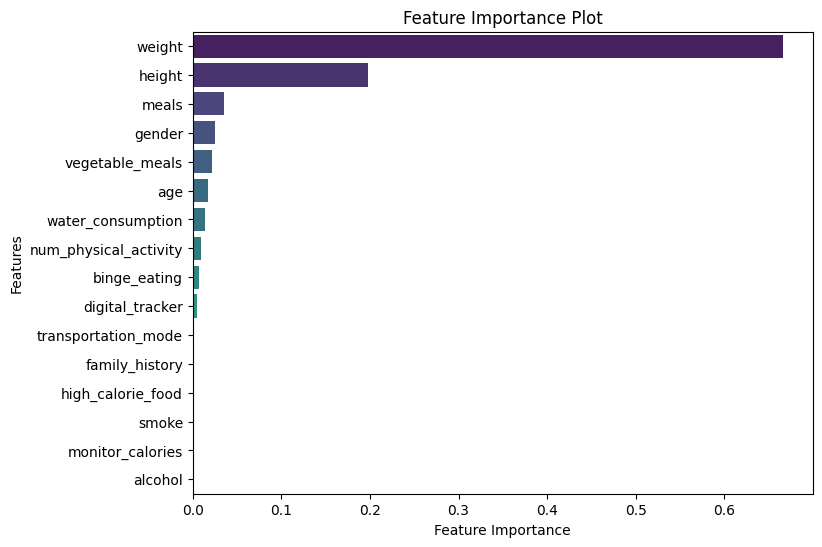

In [17]:
# Assuming numerical_features and categorical_features are lists
imp = pd.DataFrame()
imp['col'] = numerical_features + categorical_features
imp['imp'] = best_model.feature_importances_
imp = imp.sort_values(by='imp', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='imp', y='col', data=imp, palette='viridis')  # Using 'viridis' for distinct colors
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    Submit a CSV file with a header row plus each of the test entries, each on its own line. 

The file (`submissions.csv`) should have exactly 2 columns:

Column | Description
:---|:---
`id`  | Unique ID corresponding to the person
`outcome`  | Whether the person will develop a chronic disease in the future or not (1 - Yes, 0 - No)

In [18]:
test = pd.read_csv('test.csv')
test.head()

## These all steps are done above

,id,gender,age,height_weight,family_history,high_calorie_food,vegetable_meals,meals,binge_eating,smoke,water_consumption,monitor_calories,num_physical_activity,digital_tracker,alcohol,transportation_mode
0,1500,Female,nineteen,"1.779882,eighty",yes,yes,1.078529,1.211606,Sometimes,no,2.568063,no,3.000000,0.817983,no,Public_Transportation
1,1501,Female,thirty-three,"1.730379,seventy-five",yes,yes,2.013782,2.625942,Sometimes,no,1.045586,no,0.553305,0.480214,Sometimes,Automobile
2,1502,Female,23,1.5;55,yes,yes,3.000000,3.000000,Sometimes,no,2.000000,no,1.000000,0.000000,Sometimes,Motorbike
3,1503,Male,twenty-three,1.849307;one hundred and twenty-one,yes,yes,3.000000,2.510135,Sometimes,no,1.693362,no,0.769709,0.000000,Sometimes,Public_Transportation
4,1504,Female,21,1.758628;seventy-eight,yes,yes,3.000000,1.000000,Sometimes,no,2.000000,no,2.971832,0.000000,Sometimes,Public_Transportation


In [19]:
## 
submission_df = pd.DataFrame({"id": test['id'], 'outcome': test_predictions})
submission_df

,id,outcome
0,1500,0
1,1501,0
2,1502,0
3,1503,1
4,1504,0
...,...,...
316,1816,0
317,1817,1
318,1818,1
319,1819,0


In [20]:
#Submission
submission_df.to_csv('submissions.csv', index=False)

In [21]:
submission_df

,id,outcome
0,1500,0
1,1501,0
2,1502,0
3,1503,1
4,1504,0
...,...,...
316,1816,0
317,1817,1
318,1818,1
319,1819,0
